In [24]:
%cd /raid6/home/yokoyama/har-for-or/
import os
from glob import glob
import pickle
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from tqdm import tqdm

from src.data import load_dataset_iterable
from src.model import SQVAE
from src.utils import video, yaml_handler, vis

/raid6/home/yokoyama/har-for-or


In [25]:
dataset_num = 5
model_type = "sqvae"

if dataset_num == 3:
    v = 0
elif dataset_num == 4:
    v = 1
elif dataset_num == 5:
    v = 2
checkpoint_dir = f"models/individual/{model_type}/version_{v}"

# load classes
path = f"../datasets/dataset{dataset_num:02d}/annotation/classes.txt"
classes = np.loadtxt(path, str, usecols=0, delimiter=",")
classes = [c.title() for c in classes]

# load annotation
path = glob(f"../datasets/dataset{dataset_num:02d}/annotation/*test*.txt")[0]
video_num = int(os.path.basename(path).split(".")[0].split("_")[2])
annotations = np.loadtxt(path, str, skiprows=1, delimiter=" ")

# load config
config = yaml_handler.load(f"{checkpoint_dir}/individual-{model_type}.yaml")
seq_len = config.seq_len
stride = config.stride
if config.mask_leg:
    n_pts = 13 + 2
else:
    n_pts = 17 + 2

In [26]:
target_label = 3
data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/") + glob(
    f"../datasets/dataset{dataset_num:02d}/test/*/"
)
data_dirs = sorted(data_dirs, key=lambda x: int(os.path.basename(os.path.dirname(x))))

In [27]:
label_counts_all = {}
book_indices_miss_counts_all = {}
for data_dir in tqdm(data_dirs):
    video_num = os.path.basename(os.path.dirname(data_dir))

    # load preds
    results = []
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

    label_counts = {i: {} for i in range(config.n_clusters)}
    book_indices_miss_counts = {}
    pre_bi_dict = {}
    max_n_frame = 0
    for result in results:
        _, n_frame, _id = result["key"].split("_")
        n_frame = int(n_frame)
        _id = int(_id)
        bi = result["book_idx"]
        label = result["label"]

        if max_n_frame < n_frame:
            max_n_frame = n_frame

        # label count
        label_pred = int(result["label"])
        if n_frame not in label_counts[label_pred]:
            label_counts[label_pred][n_frame] = 0
        label_counts[label_pred][n_frame] += 1

        # book indices miss counts
        if label == target_label:
            if _id not in book_indices_miss_counts:
                pre_bi_dict[_id] = (n_frame, bi)
                book_indices_miss_counts[_id] = {}
            pre_nf, pre_bi = pre_bi_dict[_id]
            if pre_nf + stride == n_frame:
                miss_count = np.count_nonzero(pre_bi != bi)
                book_indices_miss_counts[_id][n_frame] = miss_count
            pre_bi_dict[_id] = (n_frame, bi)

    # collect label counts
    vals_tmp = []
    for label, count_dict in label_counts.items():
        if len(count_dict) < 2:
            continue
        n_frames = np.array(list(count_dict.keys()))
        counts = np.array(list(count_dict.values()))

        idxs = n_frames // stride
        n_samples = max_n_frame // stride + 1
        vals = np.zeros((n_samples,), np.int32)
        vals[idxs] = counts

        vals_tmp.append(vals)
    vals = np.array(vals_tmp).T
    label_counts_all[video_num] = vals

    # collect book indices miss countq
    vals_tmp = []
    for _id, count_dict in book_indices_miss_counts.items():
        if len(count_dict) < 1:
            continue
        n_frames = np.array(list(count_dict.keys()))
        counts = np.array(list(count_dict.values()))

        idxs = n_frames // stride
        n_samples = max_n_frame // stride + 1
        vals = np.zeros((n_samples,), np.int32)
        vals[idxs] = counts
        vals_tmp.append(vals)
    vals = np.array(vals_tmp).T
    book_indices_miss_counts_all[video_num] = vals

100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


In [28]:
def filter_label_counts(label_counts, label=3, th_n_label=3):
    vals = label_counts.T[label].copy()
    vals = vis.moving_average(vals, 5)
    vals = vals >= th_n_label
    return vals


def filter_book_indices_miss_counts(book_indices_miss_counts, th_n_pts, th_n_inds):
    vals = book_indices_miss_counts.copy()
    vals = np.count_nonzero(vals >= th_n_pts, axis=1)
    vals = vis.moving_average(vals, 5)
    vals = vals >= th_n_inds
    return vals


def noise_canceling(vals, th_interval):
    ret = []
    interval = 0
    flg_first_true = False
    for i, val in enumerate(vals):
        if val == 1:
            interval = 0
            ret.append(1)
            flg_first_true = True
        else:
            interval += 1
            if interval < th_interval and flg_first_true:
                ret.append(1)
            else:
                ret.append(0)

    return np.array(ret)

In [29]:
th_n_label = 3  # label count
th_n_pts = 1  # book indices
th_n_inds = 3  # book indices
th_interval = 60  # noise canceling


event_seconds_all = {}
for video_num in label_counts_all.keys():

    lc_bin = filter_label_counts(label_counts_all[video_num], target_label, th_n_label)
    lc_bin = noise_canceling(lc_bin, th_interval)

    bimc_bin = filter_book_indices_miss_counts(
        book_indices_miss_counts_all[video_num], th_n_pts, th_n_inds
    )
    bimc_bin = noise_canceling(bimc_bin, th_interval)

    binary = lc_bin & bimc_bin

    # print(video_num)
    # plt.figure(figsize=(10, 3))
    # plt.plot(lc_bin + 1.1 * 2)
    # plt.plot(bimc_bin + 1.1)
    # plt.plot(binary)
    # plt.yticks([])
    # plt.ylim(-3.3 * 0.05, 3.3 * 1.05)
    # plt.xlim(0, 1801)
    # plt.xticks(np.arange(0, 1801, 60 * 3), np.arange(0, 1801, 60 * 3) // 60)
    # plt.xlabel("Minutes")
    # plt.show()

    # diff_bin = np.diff(binary, prepend=0)
    # plt.figure(figsize=(10, 4))
    # plt.plot(diff_bin)
    # plt.yticks([])
    # plt.ylim(-1.05, 1.05)
    # plt.xlim(0, 1801)
    # plt.xticks(np.arange(0, 1801, 60 * 3), np.arange(0, 1801, 60 * 3) // 60)
    # plt.xlabel("Minutes")
    # plt.show()

    diff_bin = np.diff(binary, prepend=0)
    start_n_seconds = np.where(diff_bin > 0)[0]
    end_n_seconds = np.where(diff_bin < 0)[0]

    if np.count_nonzero(diff_bin) == 1:
        idx = np.where(diff_bin != 0)[0]
        # print(idx, diff_bin[idx].item())
        if diff_bin[idx].item() == 1:
            start_n_seconds = np.array([idx.item()])
            end_n_seconds = np.array([1800])
        else:
            start_n_seconds = np.array([0])
            end_n_seconds = np.array([idx.item()])
    elif len(start_n_seconds) == 0 and len(end_n_seconds) == 0:
        continue
    else:
        if start_n_seconds[0] > end_n_seconds[0]:
            start_n_seconds = start_n_seconds.tolist()
            start_n_seconds.append(0)
            start_n_seconds = np.array(start_n_seconds)
        if start_n_seconds[-1] > end_n_seconds[-1]:
            end_n_seconds = end_n_seconds.tolist()
            end_n_seconds.append(1800)
            end_n_seconds = np.array(end_n_seconds)
    event_seconds = np.concatenate(
        [start_n_seconds[:, None], end_n_seconds[:, None]], axis=1
    )
    event_seconds_all[video_num] = event_seconds

In [30]:
# # extract videos
# margin_sec = 60
# train_data_dirs = glob(f"../datasets/dataset{dataset_num:02d}/train/*/")
# train_video_nums = [os.path.basename(os.path.dirname(data_dir)) for data_dir in train_data_dirs]

# for video_num, event_frames in event_frames_all.items():
#     if len(event_frames) == 0:
#         continue

#     if video_num in train_video_nums:
#         data_dir = f"../datasets/dataset{dataset_num:02d}/train/{video_num}/"
#     else:
#         data_dir = f"../datasets/dataset{dataset_num:02d}/test/{video_num}/"

#     out_dir = f"{data_dir}/events"
#     os.makedirs(out_dir, exist_ok=True)

#     video_path = f"{data_dir}/pred_cluster.mp4"
#     cap = video.Capture(video_path)

#     for start_n_frame, end_n_frame in tqdm(event_frames, ncols=100, desc=video_num):
#         start_n_frame = max(0, start_n_frame - margin_sec)
#         end_n_frame = min(1800, end_n_frame + margin_sec)

#         start_n_frame *= stride
#         end_n_frame *= stride

#         out_path = f"{out_dir}/s{start_n_frame}_e{end_n_frame}.mp4"
#         wrt = video.Writer(out_path, cap.fps, cap.size)
#         cap.set_pos_frame_count(start_n_frame)
#         for i in tqdm(range(end_n_frame - start_n_frame), ncols=100):
#             frame = cap.read()[1]
#             wrt.write(frame)
#         del wrt
#     del cap

In [31]:
# def plot_heatmaps(result, fn, img_path=None, book_size=128, is_show=False):
#     vals = result[fn]
#     if fn == "book_idx":
#         fig = plt.figure(figsize=(2, 1), dpi=200)
#         vals = np.eye(book_size)[vals]
#         sns.heatmap(
#             vals,
#             annot=False,
#             cmap="Blues",
#             cbar=False,
#             xticklabels=False,
#             yticklabels=False,
#             vmin=0.0,
#         )
#     else:
#         n_layers = vals.shape[0]
#         fig = plt.figure(figsize=(n_layers, 1), dpi=200)
#         axs = fig.subplots(1, n_layers)
#         if n_layers > 1:
#             for i in range(n_layers):
#                 sns.heatmap(
#                     vals[i],
#                     annot=False,
#                     cmap="Blues",
#                     ax=axs[i],
#                     cbar=False,
#                     xticklabels=False,
#                     yticklabels=False,
#                     vmin=0.0,
#                 )
#         else:
#             vals = vals[0]
#             sns.heatmap(
#                 vals,
#                 annot=False,
#                 cmap="Blues",
#                 ax=axs,
#                 cbar=False,
#                 xticklabels=False,
#                 yticklabels=False,
#                 vmin=0.0,
#             )

#     fig.tight_layout()
#     if img_path is not None:
#         plt.savefig(img_path)
#     if is_show:
#         plt.show()
#     plt.close()

In [32]:
# video_num = 8
# n_mins = [2, 20, 22, 24, 26, 28, 30]

# for data_dir in tqdm(data_dirs):
#     if os.path.basename(os.path.dirname(data_dir)) != f"{video_num:02d}":
#         continue

#     # load preds
#     results = []
#     paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
#     for path in paths:
#         with open(path, "rb") as f:
#             results.append(pickle.load(f))

# for n_min in n_mins:
#     n_frame = n_min * 60 * stride
#     results_tmp = [r for r in results if int(r["key"].split("_")[1]) == n_frame]

#     img_dir = f"../datasets/dataset{dataset_num:02d}/images/heatmaps"
#     feature_names = ["attn_w", "attn_w_cls", "book_idx"]
#     for label in range(config.n_clusters):
#         for result in results_tmp:
#             if result["label"] == label:
#                 _id = result["id"]
#                 for fn in feature_names:
#                     img_path = f"{img_dir}/{fn}/label{label}/dataset{dataset_num:02d}_video{video_num:02d}_min{n_min}_id{_id}.png"
#                     os.makedirs(os.path.dirname(img_path), exist_ok=True)
#                     plot_heatmaps(result, fn, img_path)

In [33]:
results = []
for data_dir in tqdm(data_dirs):
    # load preds
    paths = glob(os.path.join(data_dir, f"pred_{model_type}", "*"))
    for path in paths:
        with open(path, "rb") as f:
            results.append(pickle.load(f))

100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


In [34]:
from sklearn.cluster import KMeans

k = 4
params = dict(
    n_clusters=k,
    # max_iter=1000,
    # tol=1e-8,
    random_state=42,
)
kmean_lst_attn_w = [KMeans(**params) for _ in range(config.n_clusters)]
# kmean_lst_attn_w_cls = [KMeans(**params) for _ in range(config.n_clusters)]
# kmean_lst_book_idx = [KMeans(**params) for _ in range(config.n_clusters)]
kmean_lst_ze = [KMeans(**params) for _ in range(config.n_clusters)]
kmean_lst_zq = [KMeans(**params) for _ in range(config.n_clusters)]

In [35]:
feature_names = ["attn_w", "attn_w_cls", "book_idx", "ze", "zq"]
kmeans_results = {fn: [] for fn in feature_names}
for fn in feature_names:
    for label in tqdm(range(config.n_clusters)):
        sample_keys = [r["key"] for r in results if r["label"] == label]
        X = np.array([r[fn].ravel() for r in results if r["label"] == label])
        bboxs = np.array([r["bbox"].ravel() for r in results if r["label"] == label])
        if fn == "attn_w":
            preds = kmean_lst_attn_w[label].fit_predict(X)
        # elif fn == "attn_w_cls":
        #     preds = kmean_lst_attn_w_cls[label].fit_predict(X)
        # elif fn == "book_idx":
        #     preds = kmean_lst_book_idx[label].fit_predict(X)
        elif fn == "ze":
            preds = kmean_lst_ze[label].fit_predict(X)
        elif fn == "zq":
            preds = kmean_lst_zq[label].fit_predict(X)

        for sample_key, x, bbox, pred in zip(sample_keys, X, bboxs, preds):
            kmeans_results[fn].append((sample_key, label, x, bbox, pred))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:08<00:00,  1.77s/it]


In [36]:
target_fn = "ze"
img_dir_kmeans = f"../datasets/dataset{dataset_num:02d}/images/kmeans/{target_fn}/k{k}"
os.makedirs(img_dir_kmeans, exist_ok=True)

In [37]:
def plot_label_counts_cumsum(
    label_counts,
    classes,
    frame_count,
    stride,
    mv_size=30,
    figpath=None,
    is_show=False,
    ylim=(0, 10.5),
):
    cm = plt.get_cmap("tab10")
    n_samples = frame_count // stride + 1
    fig = plt.figure(figsize=(12, 3 * config.n_clusters))
    axs = fig.subplots(config.n_clusters, 1)
    for target_label in range(config.n_clusters):
        ax1 = axs[target_label]

        vals_dict = {i: np.zeros((n_samples,), np.float32) for i in range(k)}
        for label, count_dict in label_counts.items():
            if label // k != target_label:
                continue
            if len(count_dict) < 2:
                continue
            n_frames = np.array(list(count_dict.keys()))
            counts = np.array(list(count_dict.values()))

            idxs = n_frames // stride
            vals_dict[label % k][idxs] = counts

        vals = np.array(list(vals_dict.values())).T

        # moving average
        for i in range(vals.shape[1]):
            vals.T[i] = vis.moving_average(vals.T[i], mv_size)

        vals_cumsum = np.cumsum(vals[:, ::-1], axis=1)
        x = np.arange(n_samples)
        for label, val in zip(list(range(k))[::-1], vals_cumsum.T):
            c = cm(label)
            if label == len(classes) - 1:
                y1 = np.zeros((n_samples,))
            ax1.fill_between(x, y1, val, facecolor=c, label=classes[label], alpha=0.7)
            y1 = val

            ax1.set_xlim(0, n_samples)
            ax1.set_xticks(np.arange(0, 1801, 60 * 3), np.arange(0, 1801, 60 * 3) // 60)
            ax1.set_ylabel("Number of Individuals")
            ax1.set_ylim(ylim)
            ax1.set_yticks(np.arange(ylim[0], np.ceil(ylim[1]), 2))
        ax1_handles, ax1_labels = ax1.get_legend_handles_labels()
        handles = ax1_handles[::-1]
        labels = ax1_labels[::-1]
        ax1.legend(handles, labels, bbox_to_anchor=(1.01, 1), loc="upper left")

    ax1.set_xlabel("Minutes")

    if figpath is not None:
        plt.savefig(figpath, bbox_inches="tight", dpi=300)
    if is_show:
        plt.show()
    plt.close()

In [38]:
# classes = [f"{i}-{j}" for i in range(config.n_clusters) for j in range(k)]
# fn = target_fn
# print(fn)

# results_tmp = kmeans_results[fn]
# for video_num in range(1, 20):
#     counts = {i: {} for i in range(config.n_clusters * k)}
#     for r in results_tmp:
#         vn, n_frame, _id = r[0].split("_")
#         n_frame = int(n_frame)
#         if int(vn) != video_num:
#             continue
#         # if r[1] != label:
#         #     continue
#         idx = r[1] * k + r[4]
#         if n_frame not in counts[idx]:
#             counts[idx][n_frame] = 0
#         counts[idx][n_frame] += 1

#     if all([len(vals) == 0 for vals in counts.values()]):
#         continue

#     print("video", video_num)
#     img_path = f"{img_dir_kmeans}/kmeans_{video_num:02d}.png"
#     plot_label_counts_cumsum(
#         counts,
#         list(range(k)),
#         1800 * 30,
#         stride,
#         mv_size=3,
#         # figpath=img_path,
#         is_show=False,
#         ylim=(0, 7),
#     )

In [39]:
def plot_heatmaps_kmeans(
    x_dict, fn, n_layers, img_path=None, book_size=128, is_show=False
):
    k = len(x_dict.keys())
    if fn == "book_idx":
        fig = plt.figure(figsize=(4 * k, 3), dpi=100)
        axs = fig.subplots(1, k)
        for label_kmeans, vals in x_dict.items():
            vals = np.eye(book_size)[vals]
            sns.heatmap(
                vals,
                annot=False,
                cmap="Blues",
                ax=axs[label_kmeans],
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                vmin=0.0,
            )
            axs[label_kmeans].set_title(f"kmeans {label_kmeans}")
    elif fn == "ze" or fn == "zq":
        fig = plt.figure(figsize=(4 * k, 3), dpi=100)
        axs = fig.subplots(1, k)
        for label_kmeans, vals in x_dict.items():
            vals = vals.reshape(30, 64)
            sns.heatmap(
                vals,
                annot=False,
                cmap="seismic",
                ax=axs[label_kmeans],
                cbar=True,
                xticklabels=False,
                yticklabels=False,
                vmax=0.5,
                vmin=-0.5,
            )
            axs[label_kmeans].set_title(f"kmeans {label_kmeans}")
            axs[label_kmeans].spines[["left", "right", "bottom", "top"]].set_visible(
                True
            )
    else:
        fig = plt.figure(figsize=(3 * n_layers, 2 * k + 1), dpi=100)
        axs = fig.subplots(k, n_layers).ravel()
        for label_kmeans, vals in x_dict.items():
            if vals.ndim > 0:
                for i in range(n_layers):
                    sns.heatmap(
                        vals[i],
                        annot=False,
                        cmap="Blues",
                        ax=axs[label_kmeans * n_layers + i],
                        cbar=True,
                        xticklabels=False,
                        yticklabels=False,
                        # vmin=-1.0,
                        # vmax=1.0
                    )
                    axs[label_kmeans * n_layers + i].set_title(
                        f"k {label_kmeans}, layer {i}"
                    )
            else:
                for i in range(n_layers):
                    ax = axs[label_kmeans * n_layers + i]
                    ax.set_xticks([])
                    ax.set_yticks([])
                    ax.tick_params(axis="both", color="w")
                    ax.spines[["left", "right", "bottom", "top"]].set_visible(False)
                    ax.set_title(f"k {label_kmeans}, layer {i}")

    fig.tight_layout()
    if img_path is not None:
        plt.savefig(img_path)
    if is_show:
        plt.show()
    plt.close()

ze label 0


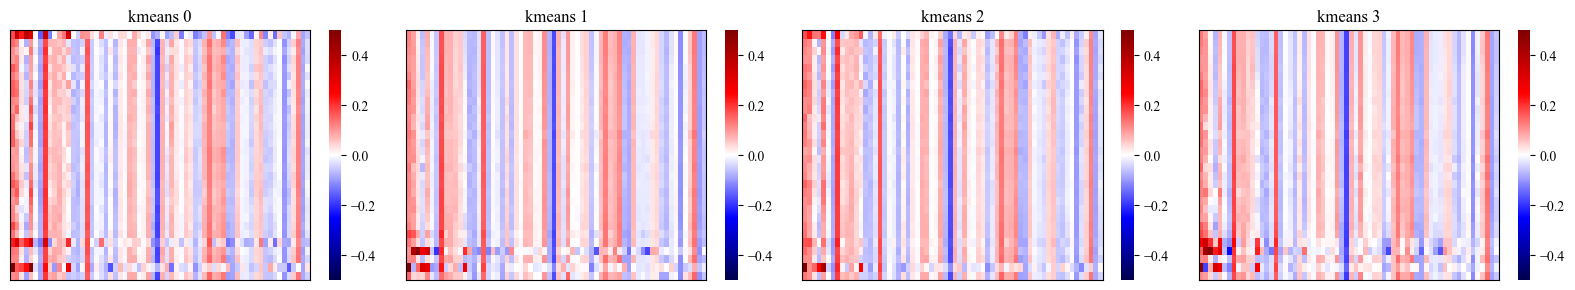

ze label 1


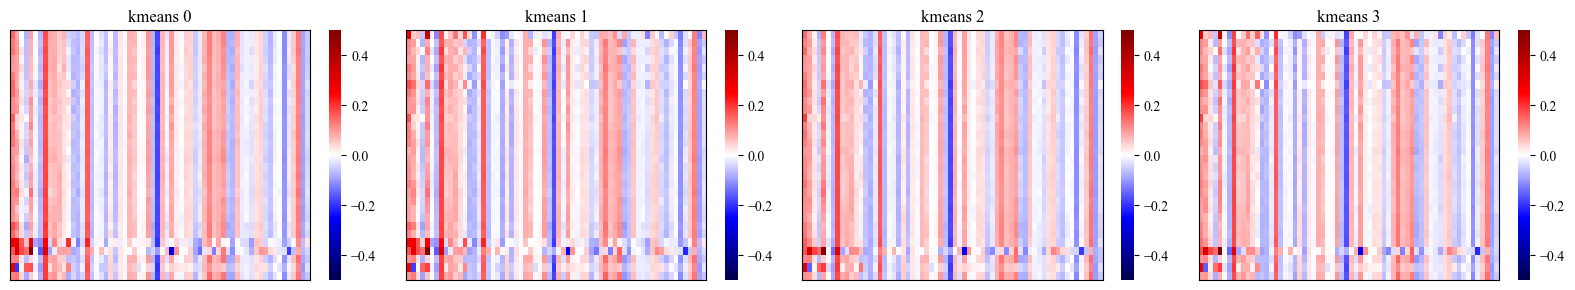

ze label 2


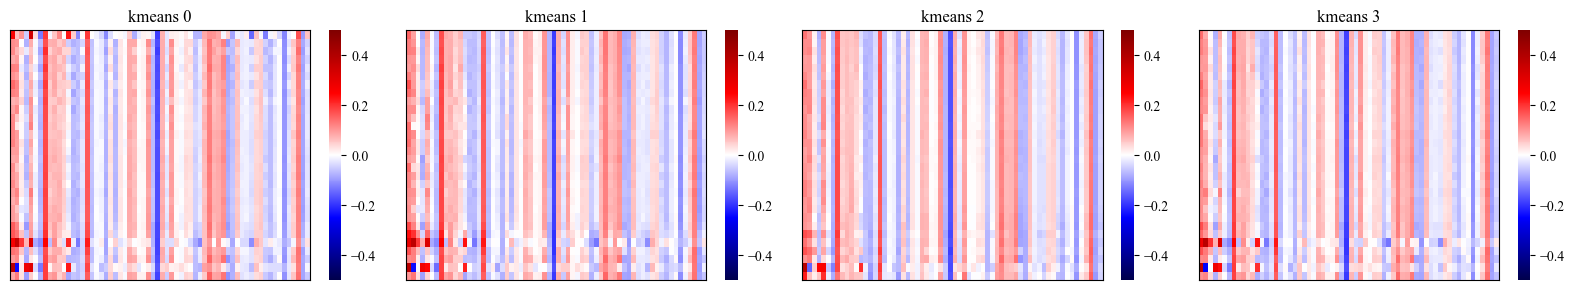

ze label 3


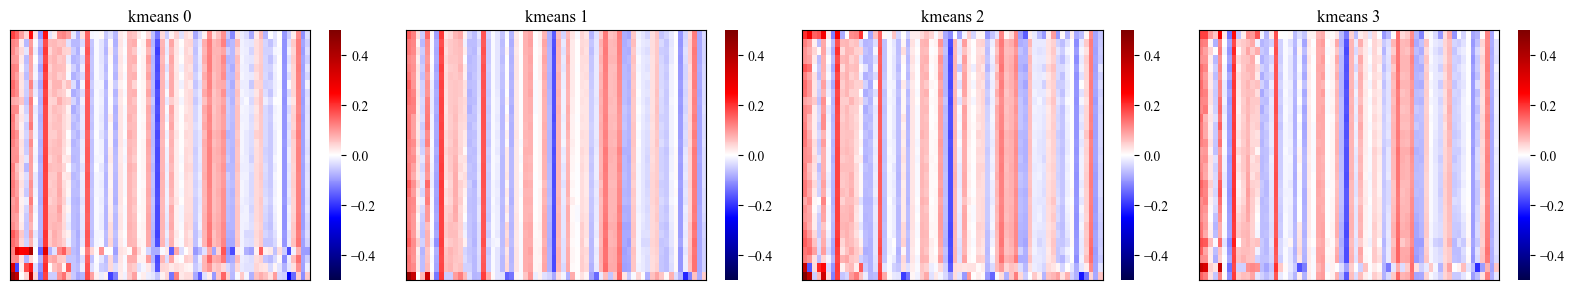

ze label 4


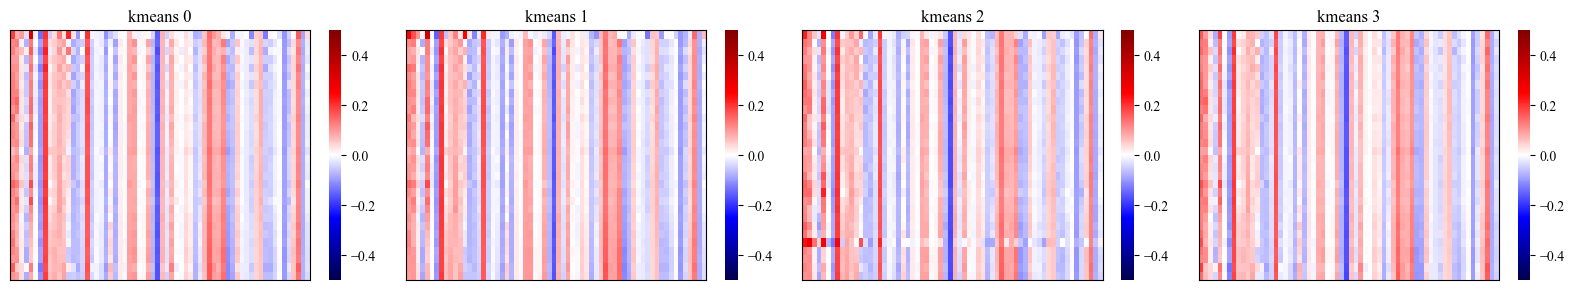

In [40]:
fn = target_fn

for label in range(config.n_clusters):
    print(fn, "label", label)
    results_tmp = kmeans_results[fn]
    x_dict = {}
    for label_kmeans in range(k):
        X = []
        for r in results_tmp:
            vn, n_frame, _id = r[0].split("_")
            if r[1] != label:
                continue
            if r[4] != label_kmeans:
                continue
            x = r[2]

            if fn == "attn_w":
                x = x.reshape(3, 30, 30)
            elif fn == "attn_w_cls":
                x = x.reshape(1, 31, 31)
            X.append(x)
        X = np.array(X).mean(axis=0)
        x_dict[label_kmeans] = X
    plot_heatmaps_kmeans(x_dict, fn, 3, is_show=True)

In [41]:
def quantize_bbox(bbox, n, seq_len, range_points):
    # quantization
    ranges = np.linspace(0, 1.0, n)
    ranges = ranges.repeat(seq_len * 2)
    ranges = ranges.reshape(n, 2, seq_len).transpose(2, 1, 0)
    ranges = ranges * (2 * range_points) - range_points
    bbox = bbox.reshape(seq_len, 2, 2)
    centers = (bbox[:, 1, :] + bbox[:, 0, :]) / 2
    idxs = np.argmin(np.abs(ranges - centers.reshape(seq_len, 2, 1)), axis=2)

    return idxs


n = 4

features_all = {}
results_tmp = kmeans_results[target_fn]
for r in tqdm(results_tmp):
    # r (sample_key, label, x, bbox, pred)
    video_num, n_frame, _id = r[0].split("_")
    video_num = int(video_num)
    n_frame = int(n_frame)
    if video_num not in features_all:
        features_all[video_num] = {}
    if n_frame not in features_all[video_num]:
        features_all[video_num][n_frame] = np.zeros((n, n, config.n_clusters * k))

    label = r[1]
    label_kmeans = r[4]
    label = label * k + label_kmeans
    idxs = quantize_bbox(r[3], n, seq_len, config.range_points)
    for i, (x, y) in enumerate(idxs):
        features_all[video_num][n_frame][x, y, label] += 1


100%|██████████| 134003/134003 [00:27<00:00, 4788.84it/s]


In [42]:
# TF-IDF
counts_dict = {}
for video_num, mapped_features in features_all.items():
    for n_frame, counts in mapped_features.items():
        key = f"{video_num}_{n_frame}"
        counts_dict[key] = counts.ravel()

n_feature_maps = len(counts_dict)
counts_arr = np.array(list(counts_dict.values()))
df = np.count_nonzero(counts_arr, axis=0)
idf = np.log((1 + n_feature_maps) / (1 + df)) + 1

tfidf_dict = {}
for key, counts in counts_dict.items():
    video_num, n_frame = key.split("_")
    video_num = int(video_num)
    n_frame = int(n_frame)
    if video_num not in tfidf_dict:
        tfidf_dict[video_num] = np.zeros((1801, n, n, config.n_clusters * k))
    tf = counts / counts.sum()
    tfidf_dict[video_num][n_frame // stride] = (tf * idf).reshape(
        n, n, config.n_clusters * k
    )


In [43]:
ed_seq_len = 1

X_dict = {}
for video_num, tf_idf in tfidf_dict.items():
    X_dict[video_num] = []
    for i in range(0, 1801 - ed_seq_len + 1):
        vals = tf_idf[i : i + ed_seq_len].reshape(-1, n * n * config.n_clusters * k)
        X_dict[video_num].append(vals)

x = []
for video_num, vals in X_dict.items():
    if video_num < 5 and 17 < video_num:
        continue
    vals = np.array(vals)
    vals = vals.reshape(-1, ed_seq_len, n * n * config.n_clusters * k)
    vals = vals.mean(axis=1)
    x += vals.tolist()

In [44]:
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA, PCA

ed_k = 6
n_components = 128

pca = PCA(n_components)
x_pca = pca.fit_transform(x)

kmeans = KMeans(ed_k, random_state=42)
kmeans = kmeans.fit(x_pca)

In [45]:
pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()

(array([   0.082849,    0.056088,    0.052394,    0.048661,    0.044616,    0.044255,    0.040649,    0.039585,    0.038381,    0.033018,     0.03146,    0.031323,    0.030362,    0.028689,    0.026576,    0.025255,    0.024801,    0.024022,    0.022666,    0.022513,    0.020572,     0.02009,    0.019127,    0.017431,
           0.016661,    0.015177,    0.015112,    0.014373,    0.013403,    0.012014,   0.0098219,   0.0093769,   0.0086522,   0.0074518,   0.0052687,   0.0046717,   0.0035477,   0.0031707,   0.0029356,    0.002845,   0.0027253,   0.0022931,    0.001948,   0.0018958,   0.0018428,   0.0018344,   0.0017505,   0.0016633,
          0.0011816,   0.0010842,   0.0010499,  0.00095328,  0.00087796,   0.0008311,  0.00082411,  0.00076232,  0.00067881,  0.00065334,  0.00062837,  0.00062207,  0.00061293,  0.00057431,  0.00055293,  0.00036723,  0.00027427,  0.00017399,  0.00015967,  0.00015607,  0.00012879,   0.0001254,  0.00010673,  9.1101e-05,
         8.1539e-05,  7.8087e-05,  7.654

video 1


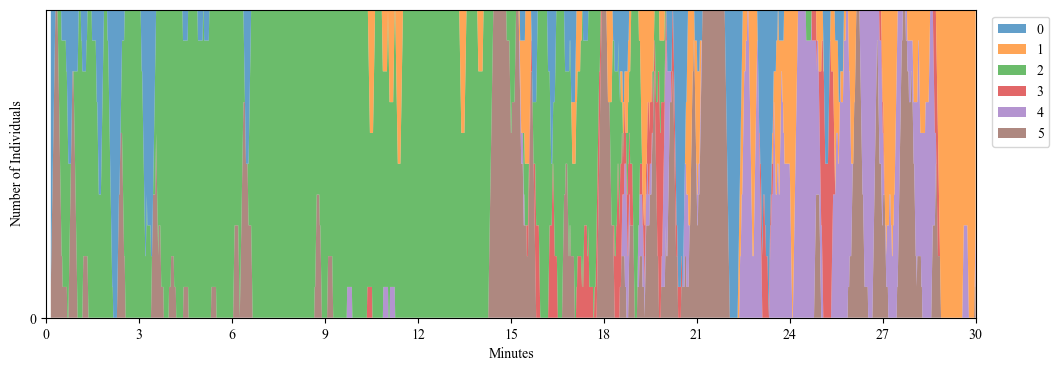

video 2


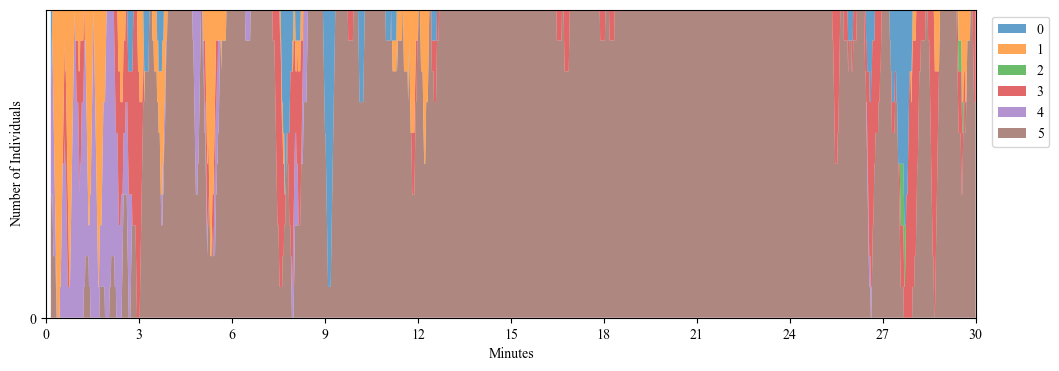

video 3


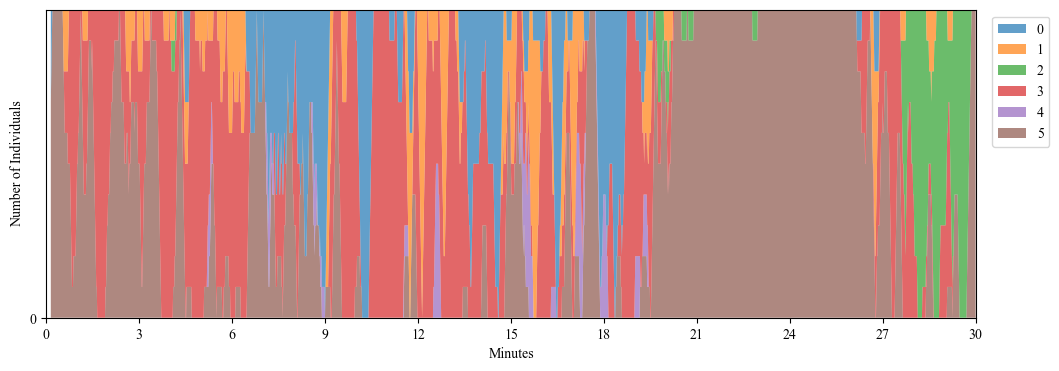

video 4


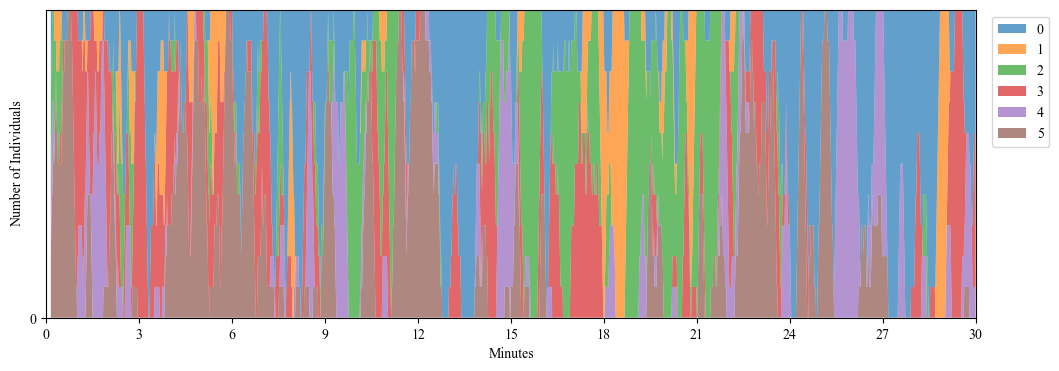

video 5


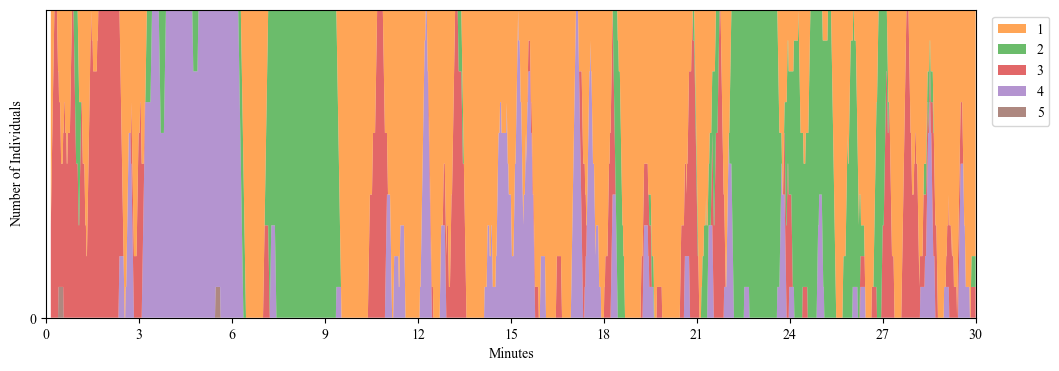

video 6


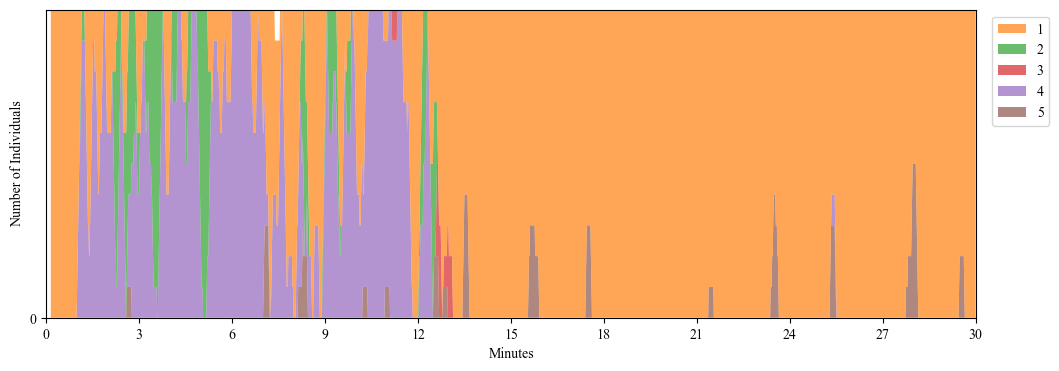

video 7


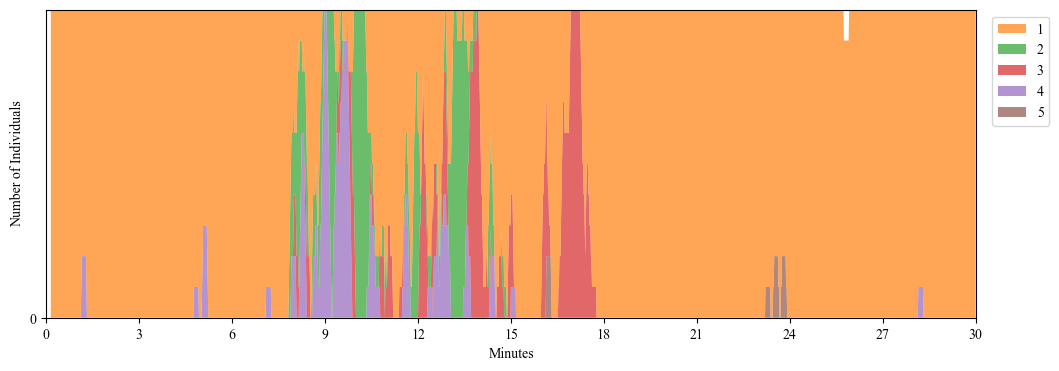

video 8


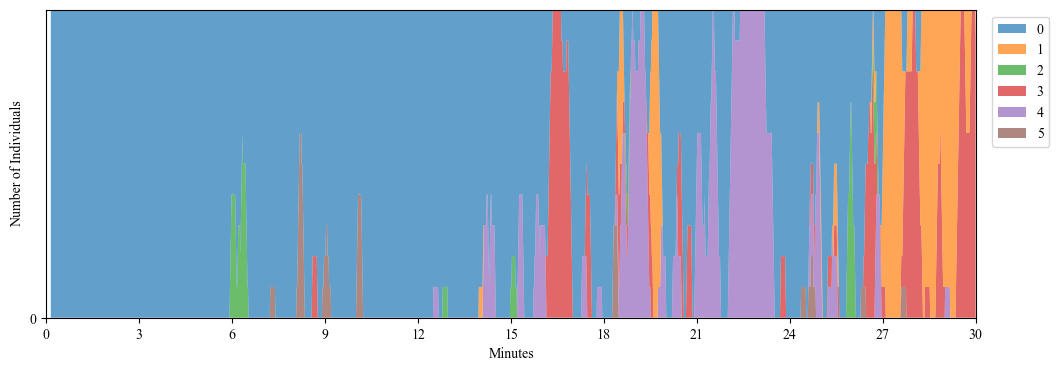

video 9


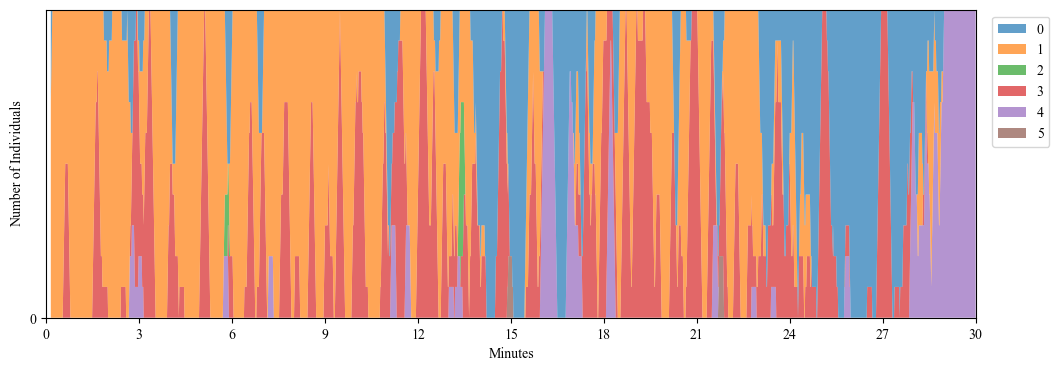

video 10


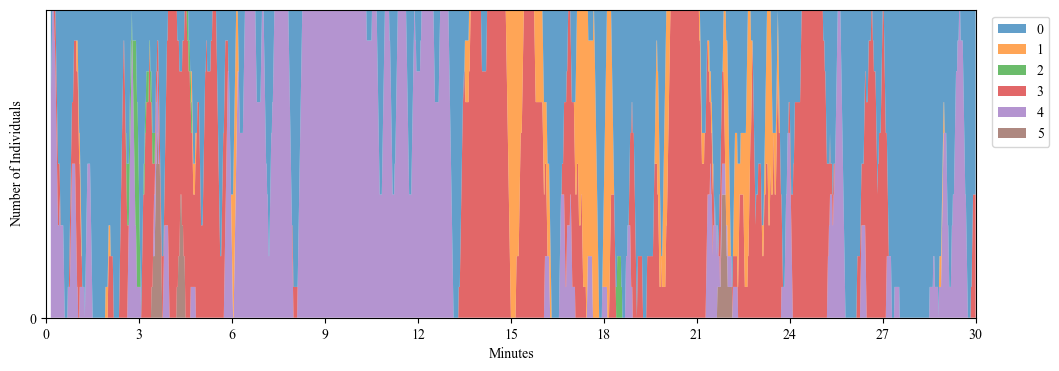

video 11


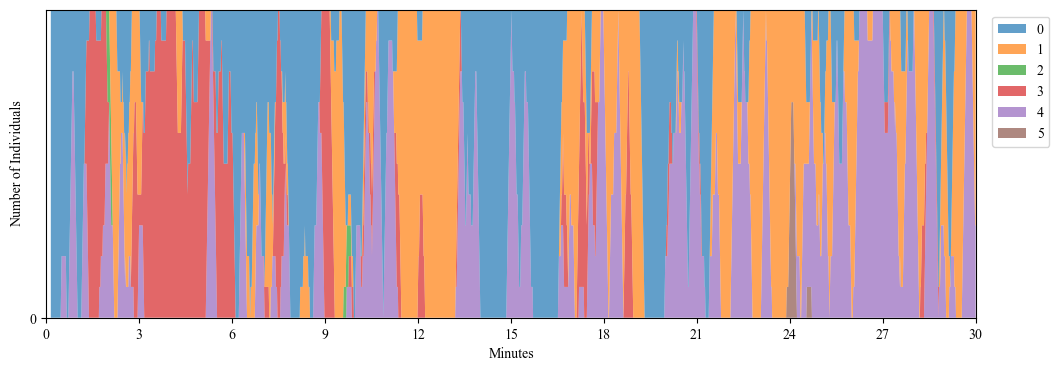

video 12


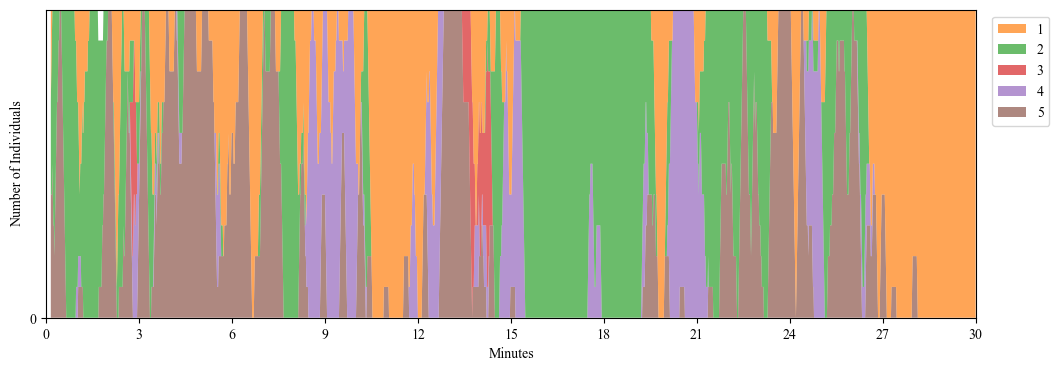

video 13


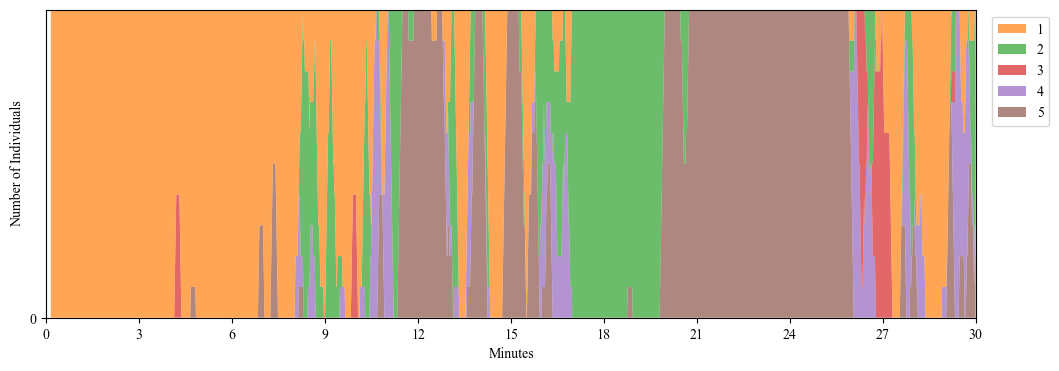

video 14


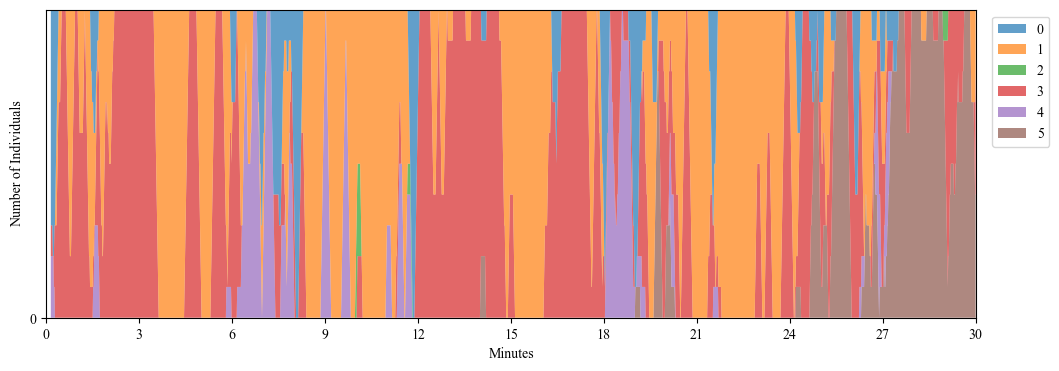

video 15


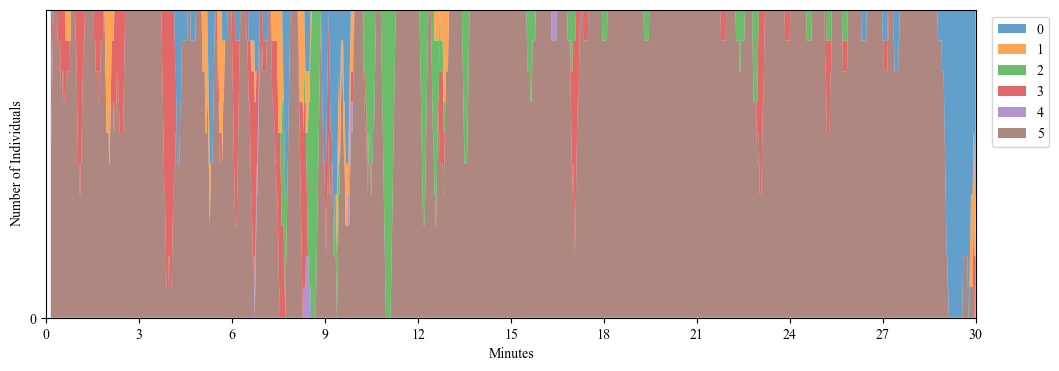

In [46]:
for video_num, vals in X_dict.items():
    vals = np.array(vals)
    vals = vals.reshape(-1, ed_seq_len, n * n * config.n_clusters * k)
    vals = vals.mean(axis=1)
    x_pca = pca.transform(vals)
    preds = kmeans.predict(x_pca)
    counts = {i: {} for i in range(ed_k)}
    for i, pred in enumerate(preds):
        n_frame = i
        if n_frame not in counts[pred]:
            counts[pred][n_frame] = 0
        counts[pred][n_frame] += 1

    print("video", video_num)
    vis.plot_label_counts_cumsum(
        counts,
        list(range(ed_k)),
        1800,
        1,
        mv_size=10,
        is_show=True,
        ylim=(0, 1),
    )
